### The Matrix Factorization Model

<img src="https://classic.d2l.ai/_images/rec-mf.svg" />

The model factorizes the user-item interaction matrix (e.g., rating matrix) $\mathbf{R} \in \mathbb{R}^{m \times n}$, where $\mathbf{R}$ represent explicit ratings, into the product of two lower-rank matrices - user latent matrix $\mathbf{P} \in \mathbb{R}^{m \times k}$ and item latent matrix $\mathbf{Q} \in \mathbb{R}^{n \times k}$, where $k \ll m, n$ capturing the low-rank structure of the user-item interactions.

Let $\mathbf{p}_u$ denote the $u^\mathrm{th}$ row of $\mathbf{P}$ and $\mathbf{q}_i$ denote the $i^\mathrm{th}$ row of $\mathbf{Q}$. For a given item $i$, the elements of $\mathbf{q}_i$ measure the extent to which the item possesses those characteristics such as the genres and languages of a movie. For a given user $u$, the elements of $\mathbf{p}_u$ measure the extent of interest the user has in items’ corresponding characteristics.


These latent factors might measure obvious dimensions as mentioned in those examples or are completely uninterpretable. The predicted ratings can be estimated by $\hat{\mathbf{R}} = \mathbf{PQ}^\top$, where $\hat{\mathbf{R}}\in \mathbb{R}^{m \times n}$ is the predicted rating matrix which has the same shape as $\mathbf{R}$.

Adjusting for biases, $\hat{\mathbf{R}}_{ui} = \mathbf{p}_u\mathbf{q}^\top_i + b_u + b_i$

Train the model - Objective function: $\underset{\mathbf{P}, \mathbf{Q}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{R}_{ui} -
\hat{\mathbf{R}}_{ui} \|^2 + \lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )$

In [2]:
!pip install mxnet==1.7.0.post1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.0 MB 109 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install d2l==0.17.5

In [1]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### Model Implementation



In [2]:
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

### Evaluation Measures

$\mathrm{RMSE} = \sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u, i) \in \mathcal{T}}(\mathbf{R}_{ui} -\hat{\mathbf{R}}_{ui})^2}$, where $\mathcal{T}$ is the set consisting of pairs of users and items that you want to evaluate on. $|\mathcal{T}|$ is the size of this set.

In [3]:
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

### Training and Evaluating the Model



In [4]:
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

train loss 0.066, test RMSE 1.053
118571.0 examples/sec on [cpu(0)]


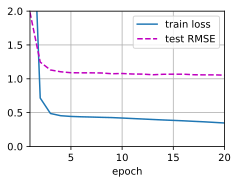

In [5]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

#### Below, we use the trained model to predict the rating that a user (ID 20) might give to an item (ID 30). 

In [6]:
scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores

array([3.0408027])